Optimized parameters from curve_fit: [ 2.60520588e+04  1.59760421e+08 -6.69238020e+01  1.11405551e+05
  1.00508671e+04  4.93183698e+05  2.67062444e+00 -1.37275187e+04
 -3.24261927e+06]


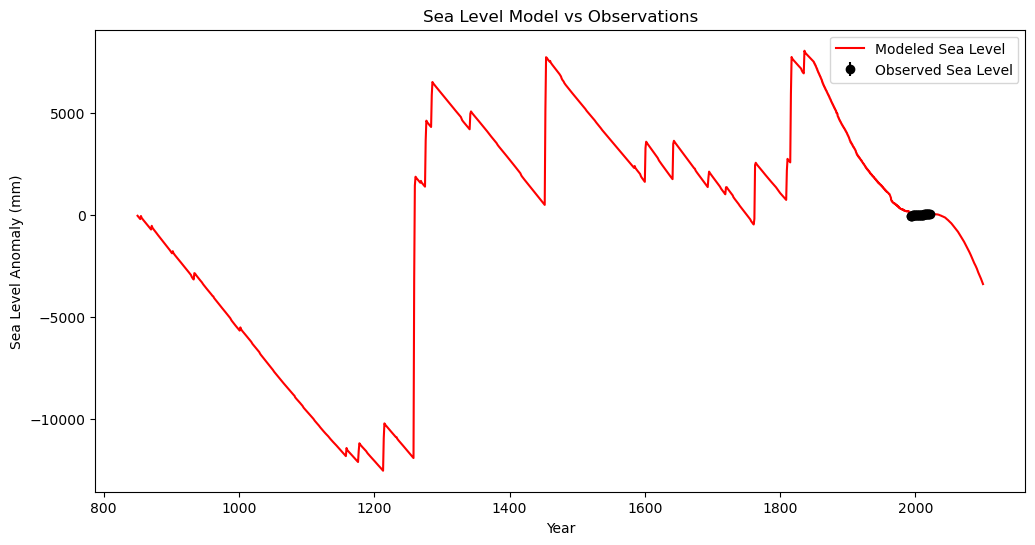

AIC: 174.8037297086965, BIC: 187.10939217857475


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/tonton/anaconda3/envs/pymc_env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:03<00:00, 2805.09it/s]


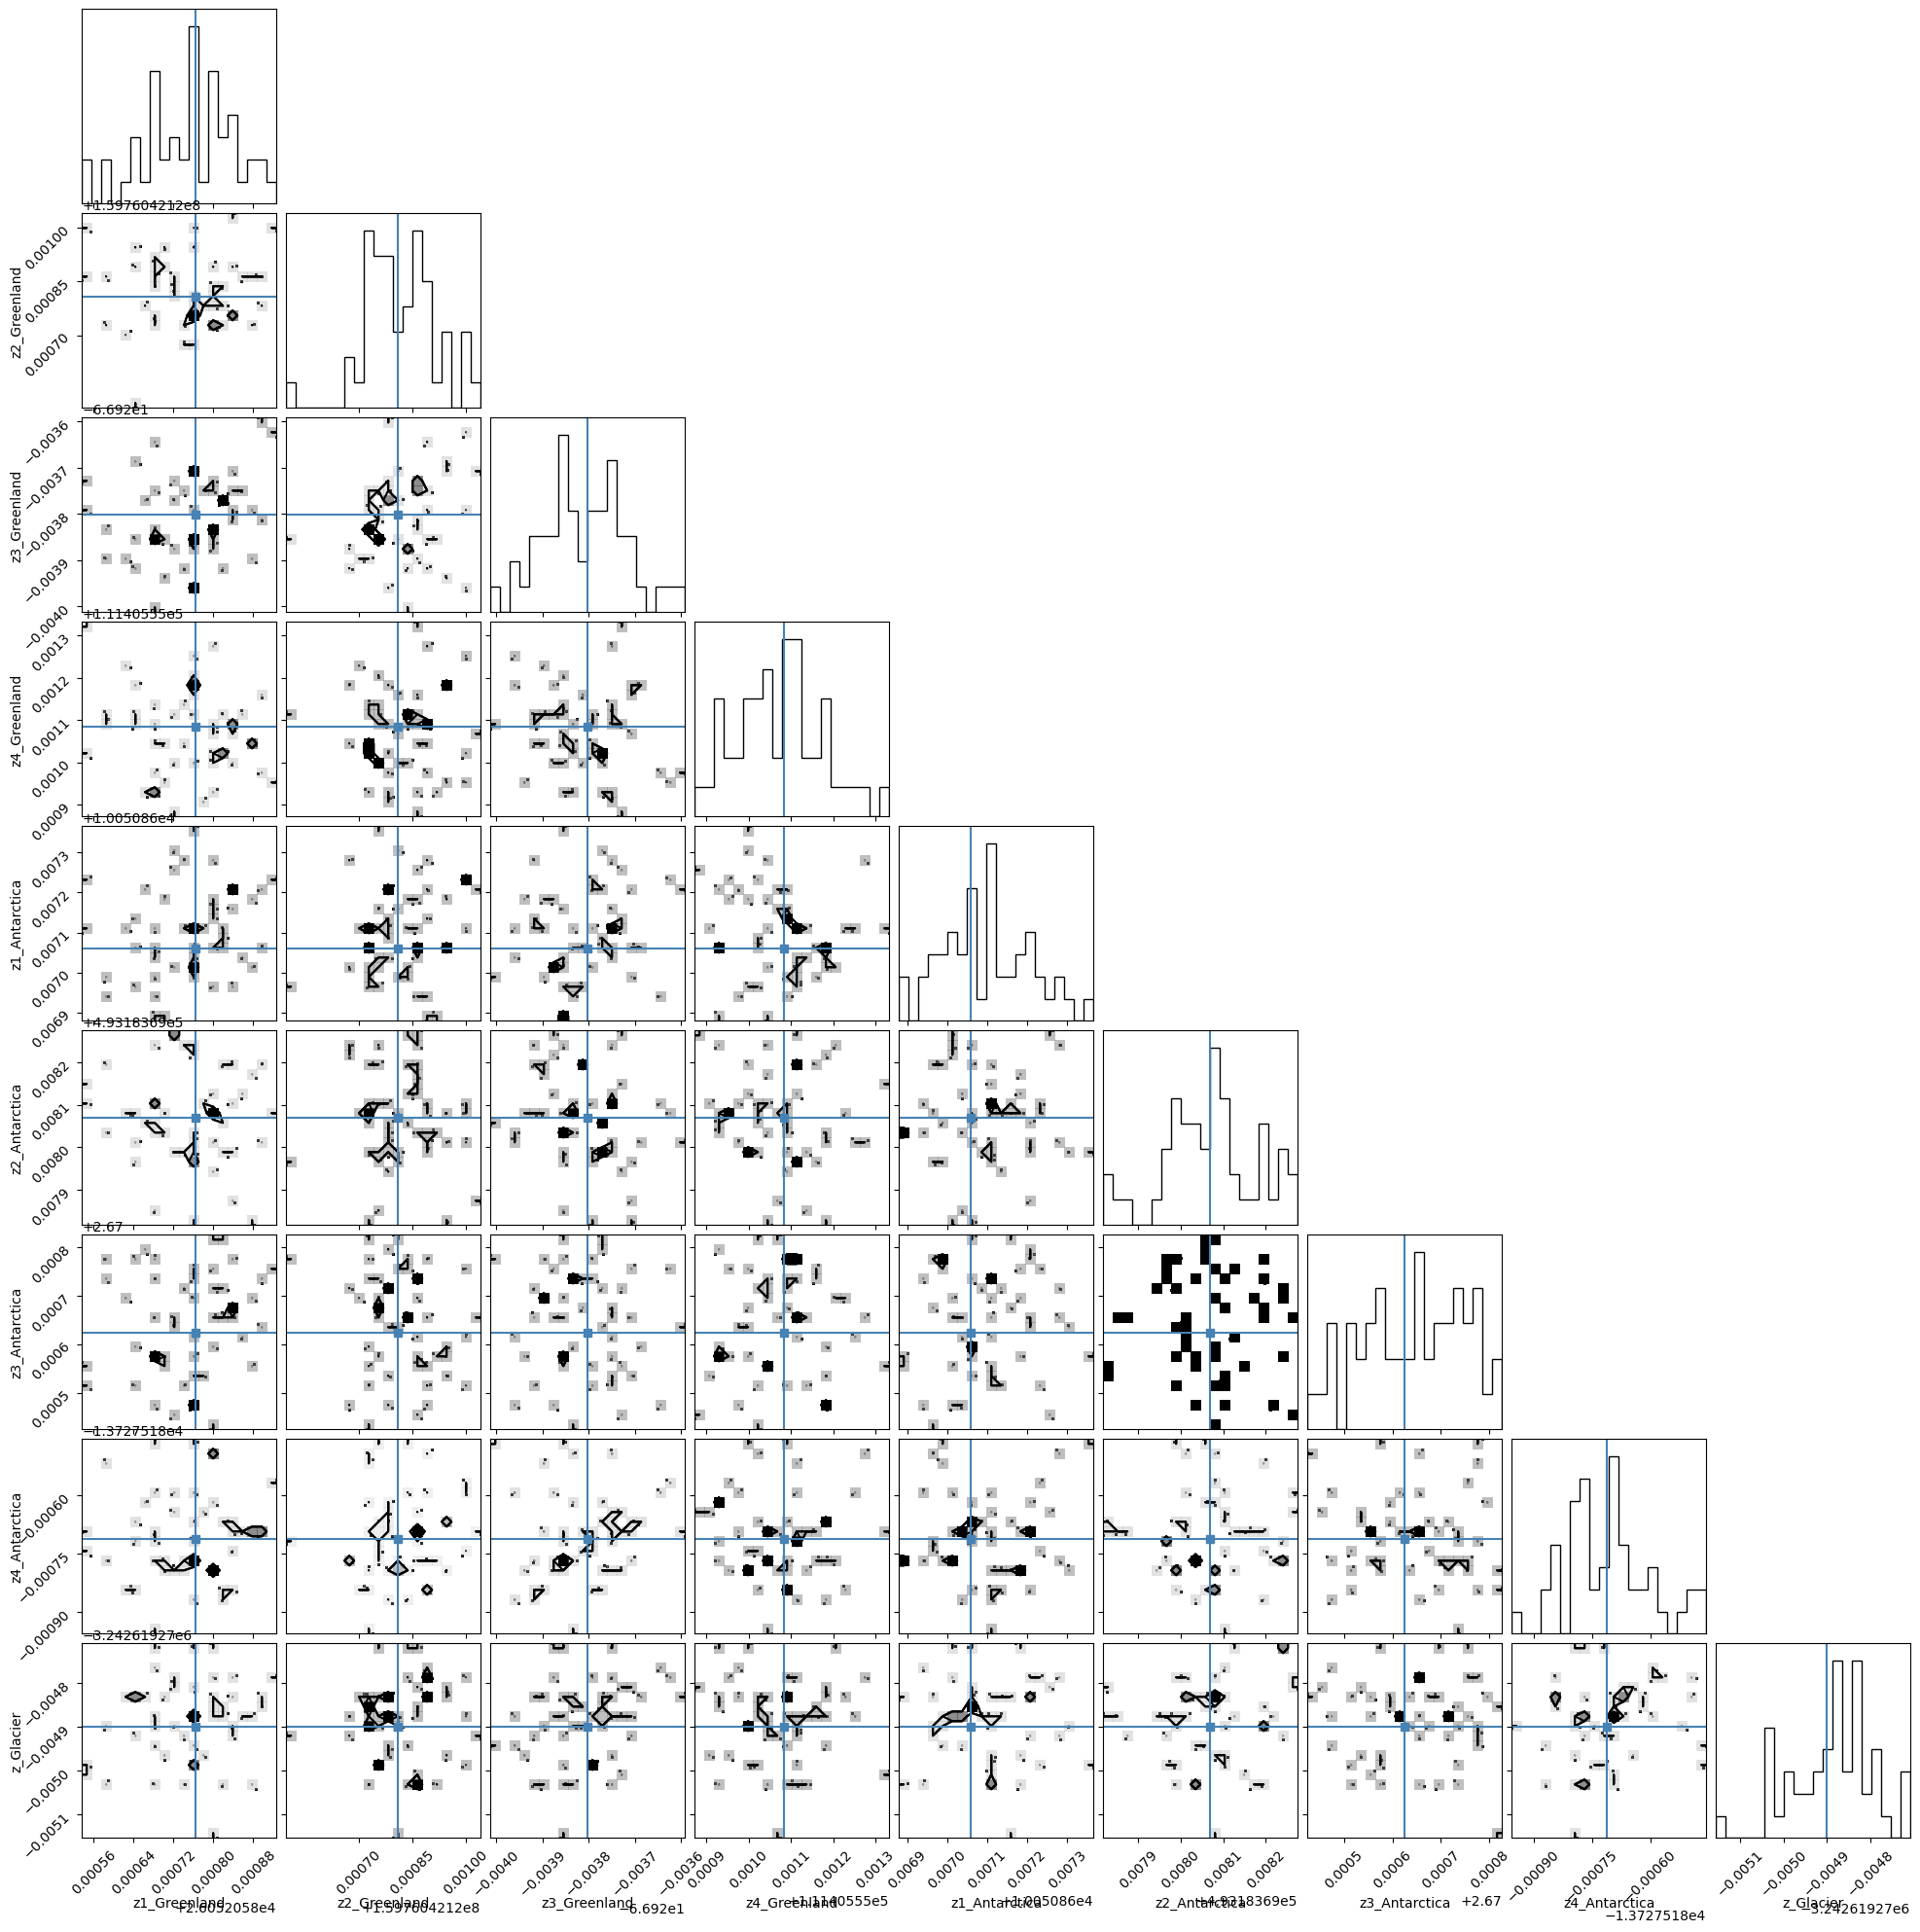

Optimized parameters from MCMC: [ 2.60520588e+04  1.59760421e+08 -6.69238159e+01  1.11405551e+05
  1.00508671e+04  4.93183698e+05  2.67065655e+00 -1.37275187e+04
 -3.24261927e+06]


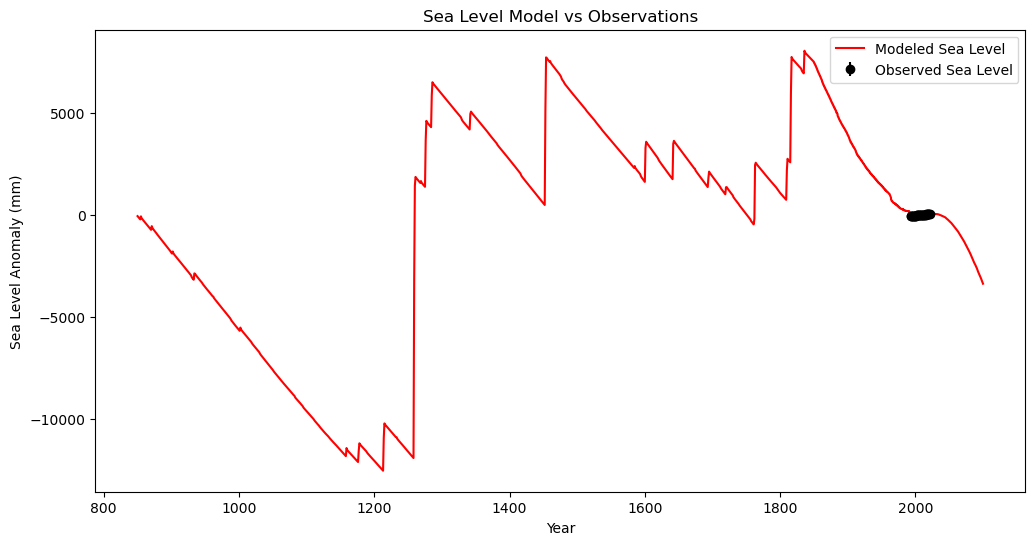

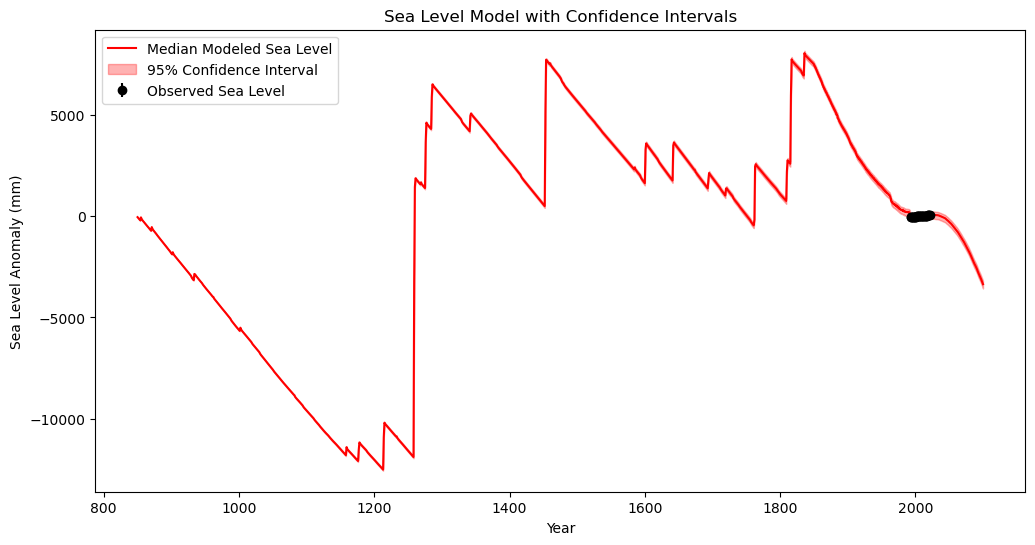

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee
import corner

# Base class for sea level models
class BaseSeaLevelModel:
    def __init__(self, df_F_path, df_S_path):
        """
        Base class for sea level models.

        Parameters:
        - df_F_path: str, path to the forcing data CSV file.
        - df_S_path: str, path to the sea level data CSV file.
        """
        # Load data
        self.df_F = pd.read_csv(df_F_path, index_col=0)
        self.df_S = pd.read_csv(df_S_path, index_col=0)
        
        # Preprocess data
        self._preprocess_data()
        
    def _preprocess_data(self):
        """
        Preprocess the data: prepare forcing and sea level data separately.
        """
        # Ensure indices are integers (years)
        self.df_F.index = self.df_F.index.astype(int)
        self.df_S.index = self.df_S.index.astype(int)

        # Forcing data (full time series)
        self.F_full = self.df_F['total'].values
        self.years_full = self.df_F.index.values

        # Observed sea level data
        self.SL_obs = self.df_S['GMSL_noGIA'].values
        self.SL_unc = self.df_S['uncertainty'].values
        self.years_obs = self.df_S.index.values.astype(int)

        # Align forcing data with observed data for likelihood computation
        common_years = np.intersect1d(self.years_full, self.years_obs)
        F_obs_indices = np.isin(self.years_full, common_years)
        SL_obs_indices = np.isin(self.years_obs, common_years)

        self.F_obs = self.F_full[F_obs_indices]
        self.years_common = self.years_full[F_obs_indices]

        # Re-order sea level observations to match the years in common
        SL_obs_order = np.argsort(self.years_obs[SL_obs_indices])
        self.SL_obs = self.SL_obs[SL_obs_indices][SL_obs_order]
        self.SL_unc = self.SL_unc[SL_obs_indices][SL_obs_order]
        self.years_obs = self.years_obs[SL_obs_indices][SL_obs_order]

    def get_S(self, F, theta):
        """
        Compute the modeled sea level based on the forcing F and model parameters.

        This method should be implemented by subclasses.

        Parameters:
        - F: array-like, radiative forcing data.
        - theta: array-like, model parameters.

        Returns:
        - S: array-like, modeled sea level.
        """
        raise NotImplementedError("This method should be implemented by subclasses.")

    def log_prior(self, theta):
        """
        Compute the log prior probability of the parameters.

        This method should be implemented by subclasses.

        Parameters:
        - theta: array-like, model parameters.

        Returns:
        - lp: float, log prior probability.
        """
        raise NotImplementedError("This method should be implemented by subclasses.")

    def log_likelihood(self, theta):
        """
        Compute the log likelihood of the data given the parameters.

        Parameters:
        - theta: array-like, model parameters.

        Returns:
        - ll: float, log likelihood.
        """
        # Compute modeled sea level over full time series
        S_model_full = self.get_S(self.F_full, theta)
        # Interpolate modeled sea level at observation years
        S_model_obs = np.interp(self.years_obs, self.years_full, S_model_full)
        residuals = self.SL_obs - S_model_obs
        ll = -0.5 * np.sum((residuals / self.SL_unc) ** 2 + np.log(2 * np.pi * self.SL_unc ** 2))
        return ll

    def log_probability(self, theta):
        """
        Compute the total log probability (log prior + log likelihood).

        Parameters:
        - theta: array-like, model parameters.

        Returns:
        - lp + ll: float, total log probability.
        """
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta)

    def curve_fit_model(self):
        """
        Fit the sea level model to the data using scipy's curve_fit.

        Returns:
        - popt: array, optimized parameters.
        - pcov: 2D array, covariance of the optimized parameters.
        """
        # Wrapper function for curve_fit
        def model_func(F_obs, *theta):
            # Compute modeled sea level over full time series
            S_model_full = self.get_S(self.F_full, theta)
            # Extract modeled sea level at observation years
            S_model_obs = np.interp(self.years_obs, self.years_full, S_model_full)
            return S_model_obs

        # Initial guess for the parameters
        initial_guess = self.initial_guess()

        # Perform curve fitting
        popt, pcov = curve_fit(
            model_func, self.F_obs, self.SL_obs, sigma=self.SL_unc,
            p0=initial_guess, absolute_sigma=True, maxfev=10000
        )
        return popt, pcov

    def run_mcmc(self, initial_guess, nwalkers=32, nsteps=5000):
        """
        Run MCMC sampling to estimate the posterior distribution of the parameters.

        Parameters:
        - initial_guess: array-like, initial guess of the parameters.
        - nwalkers: int, number of MCMC walkers.
        - nsteps: int, number of steps in MCMC chain.

        Returns:
        - sampler: emcee.EnsembleSampler object.
        - samples: 2D array, sampled parameter values.
        """
        ndim = len(initial_guess)
        # Initialize walkers around the initial guess
        pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_probability)

        # Run MCMC
        sampler.run_mcmc(pos, nsteps, progress=True)

        # Flatten the chain and discard burn-in samples
        samples = sampler.get_chain(discard=int(nsteps / 2), thin=15, flat=True)
        return sampler, samples

    def compute_aic_bic(self, theta):
        """
        Compute AIC and BIC for the model.

        Parameters:
        - theta: array-like, model parameters.

        Returns:
        - aic: float, Akaike Information Criterion.
        - bic: float, Bayesian Information Criterion.
        """
        ll = self.log_likelihood(theta)
        k = len(theta)  # Number of parameters
        n = len(self.SL_obs)  # Number of observations

        aic = 2 * k - 2 * ll
        bic = np.log(n) * k - 2 * ll

        return aic, bic

    def plot_model(self, theta):
        """
        Plot the observed sea level data and the model prediction over the full time series.

        Parameters:
        - theta: array-like, model parameters.
        """
        S_model_full = self.get_S(self.F_full, theta)
        plt.figure(figsize=(12, 6))
        # Plot modeled sea level over full time range
        plt.plot(self.years_full, S_model_full, label='Modeled Sea Level', color='red')
        # Plot observed sea level data
        plt.errorbar(self.years_obs, self.SL_obs, yerr=self.SL_unc,
                     fmt='o', label='Observed Sea Level', color='black')
        plt.xlabel('Year')
        plt.ylabel('Sea Level Anomaly (mm)')
        plt.title('Sea Level Model vs Observations')
        plt.legend()
        plt.show()

    def initial_guess(self):
        """
        Generate an initial guess for the model parameters.

        This method should be implemented by subclasses.

        Returns:
        - initial_guess: array-like, initial parameter values.
        """
        raise NotImplementedError("This method should be implemented by subclasses.")

# Complex sea level model class
class ComplexSeaLevelModel(BaseSeaLevelModel):
    def __init__(self, df_F_path, df_S_path, constants, lambda_temp):
        """
        Complex sea level model incorporating contributions from Greenland, Antarctica, glaciers, and thermal expansion.

        Parameters:
        - df_F_path: str, path to the forcing data CSV file.
        - df_S_path: str, path to the sea level data CSV file.
        - constants: dict, constants for each component.
        - lambda_temp: float, climate sensitivity parameter (K per W/m^2).
        """
        super().__init__(df_F_path, df_S_path)
        self.constants = constants
        self.lambda_temp = lambda_temp

    def get_S(self, F, theta):
        """
        Compute the modeled sea level based on the forcing F and model parameters.

        Parameters:
        - F: array-like, radiative forcing data.
        - theta: array-like, model parameters (scaling factors for each component).

        Returns:
        - S_total: array-like, modeled sea level.
        """
        # Unpack scaling parameters
        z_greenland = theta[0:4]  # (z1, z2, z3, z4)
        z_antarctica = theta[4:8]  # (z1, z2, z3, z4)
        z_glacier = theta[8]
        # z_thermal = theta[9]  # If thermal expansion has a scaling parameter

        # Compute contributions
        S_greenland = self.greenland_contribution(F, self.constants['greenland'], z_greenland)
        S_antarctica = self.antarctica_contribution(F, self.constants['antarctica'], z_antarctica)
        S_glacier = self.glacier_contribution(F, self.constants['glacier'], z_glacier)
        S_thermal = self.thermal_expansion(F, self.constants['thermal'])  # If scaling, multiply by z_thermal

        # Total sea level rise
        S_total = S_greenland + S_antarctica + S_glacier + S_thermal
        return S_total

    def delta_T(self, F):
        """
        Compute temperature change from radiative forcing.
        """
        return self.lambda_temp * F

    def precipitation(self, area, delta_T, z):
        """
        Compute precipitation rate based on temperature change.
        """
        # Water carrying capacity of air (Clausius-Clapeyron relation approximation)
        C = 6.112 * np.exp(17.67 * delta_T / (delta_T + 243.5))
        precipitation_rate = area * C * z
        return precipitation_rate

    def melt(self, length_boundary, height_avg, delta_T, T_c, z):
        """
        Compute melt rate based on temperature change.
        """
        # Area of boundary
        area = length_boundary * height_avg
        melt_rate = area * np.maximum(delta_T - T_c, 0) * z
        return melt_rate

    def discharge(self, volume_overhang, delta_T_ocean, T_c, z):
        """
        Compute discharge rate based on ocean temperature change.
        """
        discharge_rate = volume_overhang * np.maximum(delta_T_ocean - T_c, 0) * z
        return discharge_rate

    def sublimation(self, area, F, delta_T, z):
        """
        Compute sublimation rate based on radiative forcing and temperature change.
        """
        sublimation_rate = area * F * delta_T * z
        return sublimation_rate

    def greenland_contribution(self, F, constants, z_values):
        """
        Compute Greenland's sea level contribution over time.
        """
        # Unpack constants
        area = constants['area']
        length_boundary = constants['length_boundary']
        height_avg = constants['height_avg']
        volume_overhang = constants['volume_overhang']
        T_c = constants['T_c']
        area_ocean = constants['area_ocean']

        # Unpack z_values
        z1, z2, z3, z4 = z_values

        # Compute temperature changes
        delta_T_air = self.delta_T(F)
        delta_T_ocean = delta_T_air  # Assuming same for simplicity

        # Compute each term vectorized
        P = self.precipitation(area, delta_T_air, z1)
        L = self.melt(length_boundary, height_avg, delta_T_air, T_c, z2)
        D = self.discharge(volume_overhang, delta_T_ocean, T_c, z3)
        B = self.sublimation(area, F, delta_T_air, z4)

        # Mass change (positive mass loss contributes to sea level rise)
        mass_change = (L + D + B) - P

        # Sea level change
        dS = mass_change / area_ocean

        # Cumulative sea level rise
        S_greenland = np.cumsum(dS)
        return S_greenland

    def antarctica_contribution(self, F, constants, z_values):
        """
        Compute Antarctica's sea level contribution over time.
        """
        # Unpack constants
        area = constants['area']
        length_boundary = constants['length_boundary']
        height_avg = constants['height_avg']
        volume_overhang = constants['volume_overhang']
        T_c = constants['T_c']
        area_ocean = constants['area_ocean']

        # Unpack z_values
        z1, z2, z3, z4 = z_values

        # Compute temperature changes
        delta_T_air = self.delta_T(F)
        delta_T_ocean = delta_T_air  # Assuming same for simplicity

        # Compute each term vectorized
        P = self.precipitation(area, delta_T_air, z1)
        L = self.melt(length_boundary, height_avg, delta_T_air, T_c, z2)
        D = self.discharge(volume_overhang, delta_T_ocean, T_c, z3)
        B = self.sublimation(area, F, delta_T_air, z4)

        # Mass change
        mass_change = (L + D + B) - P

        # Sea level change
        dS = mass_change / area_ocean

        # Cumulative sea level rise
        S_antarctica = np.cumsum(dS)
        return S_antarctica

    def glacier_contribution(self, F, constants, z):
        """
        Compute glacier contribution to sea level rise.
        """
        # Unpack constants
        area_glaciers = constants['area_glaciers']
        melt_factor = constants['melt_factor']
        area_ocean = constants['area_ocean']

        # Compute temperature change
        delta_T_glacier = self.delta_T(F)

        # Simplified melt rate
        melt_rate = area_glaciers * delta_T_glacier * melt_factor * z

        # Sea level change
        dS = melt_rate / area_ocean

        # Cumulative sea level rise
        S_glacier = np.cumsum(dS)
        return S_glacier

    def thermal_expansion(self, F, constants):
        """
        Compute thermal expansion contribution to sea level rise.
        """
        # Compute temperature change
        delta_T_ocean = self.delta_T(F)

        # Sea level rise due to thermal expansion
        S_thermal = constants['alpha'] * constants['depth_ocean'] * delta_T_ocean
        return S_thermal

    def log_prior(self, theta):
        """
        Compute the log prior probability of the parameters.
        """
        # Sensible priors: scaling parameters should be positive
        if not np.all(np.array(theta) > 0):
            return -np.inf
        # Add more priors as necessary
        return 0.0  # Uniform prior within bounds

    def initial_guess(self):
        """
        Generate an initial guess for the model parameters.
        """
        return [1.0] * 9  # 9 scaling parameters

    def parameter_labels(self):
        """
        Generate labels for the parameters for plotting.
        """
        labels = [
            'z1_Greenland', 'z2_Greenland', 'z3_Greenland', 'z4_Greenland',
            'z1_Antarctica', 'z2_Antarctica', 'z3_Antarctica', 'z4_Antarctica',
            'z_Glacier'
        ]
        return labels

    def plot_model_with_ci(self, samples, confidence=95):
        """
        Plot the observed sea level data and the model prediction with confidence intervals over the full time series.

        Parameters:
        - samples: array-like, MCMC samples of parameters.
        - confidence: float, confidence level for intervals.
        """
        percentiles = [(100 - confidence) / 2, 50, 100 - (100 - confidence) / 2]
        S_models = np.array([self.get_S(self.F_full, theta) for theta in samples])
        perc = np.percentile(S_models, [2.5, 50, 97.5], axis=0)

        plt.figure(figsize=(12, 6))
        # Plot observed sea level data
        plt.errorbar(self.years_obs, self.SL_obs, yerr=self.SL_unc,
                     fmt='o', label='Observed Sea Level', color='black')
        # Plot median modeled sea level
        plt.plot(self.years_full, perc[1], label='Median Modeled Sea Level', color='red')
        # Plot confidence interval
        plt.fill_between(self.years_full, perc[0], perc[2],
                         color='red', alpha=0.3, label=f'{confidence}% Confidence Interval')
        plt.xlabel('Year')
        plt.ylabel('Sea Level Anomaly (mm)')
        plt.title('Sea Level Model with Confidence Intervals')
        plt.legend()
        plt.show()

# Constants for each component (values are illustrative; replace with accurate data)
constants = {
    'greenland': {
        'area': 1.71e12,  # m^2
        'length_boundary': 1.88e6,  # m
        'height_avg': 1500,  # m
        'volume_overhang': 2.9e15,  # m^3
        'T_c': -1.0,  # °C
        'area_ocean': 3.6e14  # m^2
    },
    'antarctica': {
        'area': 1.4e13,  # m^2
        'length_boundary': 1.7e7,  # m
        'height_avg': 2000,  # m
        'volume_overhang': 2.6e16,  # m^3
        'T_c': -10.0,  # °C
        'area_ocean': 3.6e14  # m^2
    },
    'glacier': {
        'area_glaciers': 7.5e12,  # m^2
        'melt_factor': 0.01,  # Adjust as needed
        'area_ocean': 3.6e14  # m^2
    },
    'thermal': {
        'alpha': 2.1e-4,  # 1/K
        'depth_ocean': 3700  # m
    }
}

# Climate sensitivity parameter
lambda_temp = 0.8  # K per W/m^2

# Paths to your data files
df_F_path = '../data/forcing_all.csv'
df_S_path = '../data/processed_sea_level_data.csv'

# Instantiate the model
model = ComplexSeaLevelModel(df_F_path, df_S_path, constants, lambda_temp)

# Initial guess for the parameters
initial_guess = model.initial_guess()

# Fit the model using curve_fit
popt, pcov = model.curve_fit_model()
print('Optimized parameters from curve_fit:', popt)

# Plot the model prediction with optimized parameters
model.plot_model(popt)

# Compute AIC and BIC
aic, bic = model.compute_aic_bic(popt)
print(f"AIC: {aic}, BIC: {bic}")

# Run MCMC sampling
sampler, samples = model.run_mcmc(popt, nwalkers=50, nsteps=10000)

# Plot the corner plot of the posterior distributions
labels = model.parameter_labels()
corner.corner(samples, labels=labels, truths=popt)
plt.show()

# Compute the median of the samples to get the best-fit parameters
theta_mcmc = np.median(samples, axis=0)
print('Optimized parameters from MCMC:', theta_mcmc)

# Plot the model prediction with MCMC parameters
model.plot_model(theta_mcmc)

# Plot model with confidence intervals
model.plot_model_with_ci(samples)
